In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
import keras
import keras.backend as K
from keras.models import Sequential
from keras import optimizers
from keras.utils.vis_utils import model_to_dot
from keras import regularizers, optimizers, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import Dense, Embedding, Flatten, Input, dot, \
        Concatenate, Dropout, merge, LSTM, RepeatVector, Activation, BatchNormalization
from keras.constraints import non_neg
from IPython.display import SVG
%matplotlib inline

/Users/Joonil/anaconda/envs/pytorch/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Read dataset

In [2]:
# Define attributes of u.item
FieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
      'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
      'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']

# Read the data into dataframes
DataDf = pd.read_csv("ml-100k/u.data", sep='\t', names=["user_id", "item_id", "rating", "timestamp"])
Itemdata = pd.read_csv("ml-100k/u.item", sep='|', encoding = "ISO-8859-1", names=FieldsMovies)

# Setups
FindID = Itemdata.movieTitle.to_dict()  # key: movieID-1, value:movie title
NumItems = len(DataDf.item_id.unique())
NumUsers = len(DataDf.user_id.unique())

In [3]:
DataDf = DataDf.drop('timestamp', axis=1)
DataDf.head()

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [4]:
DataDf.describe()

,user_id,item_id,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


Let's see how many unique users and items (movies) in the dataset.

In [5]:
print("Number of Users: {}\nNumber of Movies: {}".format(NumUsers, NumItems))

Number of Users: 943
Number of Movies: 1682


### Train Test Split

In [6]:
train, test = train_test_split(DataDf, test_size=0.2)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

## Cosine Similarity
A simple recommender system using item-item similarity or user-user similarity.

In [7]:
watched = train.loc[train.user_id==1].item_id.as_matrix()

In [8]:
def buildItemUserMatrix(dataDf):
    '''
    Input
    - datadf: A pandas dataframe of movielens dataset

    Ouput
    - matrix: A 2d numpy array of Item-User Matrix (numItems x numUsers)
    '''
    dataMatrix = np.zeros((NumItems, NumUsers), dtype=np.int8)

    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating) in dataDf.itertuples():
        dataMatrix[itemID-1, userID-1] = rating
    return dataMatrix

def getSimilarMovies(similarity, movieID, k=5):
    '''
    Recommend k-number of similar movie by cosine similarity metric
    '''
    movieVec = similarity[movieID-1]
    movieVec = np.delete(movieVec, movieID-1)
    sortedIdx = np.argsort(movieVec)[::-1]
    print("Did you like '{}'?\n".format(FindID[movieID-1]))
    print("What we recommend for you")
    for i in range(k):
        movietitle = FindID[sortedIdx[i+1]+1]
        print("{}: {}".format(i+1, movietitle))

def whichMovie(movieID):
    return FindID[movieID-1]

def predictRatings(trainDf, dataMatrix, similarity):
    '''
    Predict empty ratings by using item-item cosine similarity
    '''
#     dataMatrix = buildItemUserMatrix(trainDf)
    predictionMatrix = np.zeros((NumItems, NumUsers))
    
    # loop over non-rated items
    for u in range(NumUsers):
        userVector = dataMatrix[:,u]
        nonzeros = userVector.nonzero()
        itemRatings = userVector[nonzeros]
        zeros = np.argwhere(userVector == 0).flatten()

        for i in zeros:
            # Get the similarity score for each of the items that provided rating by this user
            itemSims = similarity[i,:][nonzeros]

            if itemSims.sum() == 0:
                predictionMatrix[i,u] = userVector.mean()
            else:
                #Predict score based on item-item similarity
                predictionMatrix[i,u] = (itemRatings * itemSims).sum() / itemSims.sum()
    
    return predictionMatrix

def predictRatings2(trainDf, dataMatrix, similarity):
    '''
    Predict empty ratings by using user-user cosine similarity
    '''
#     dataMatrix = buildItemUserMatrix(trainDf)
    predictionMatrix = np.zeros((NumItems, NumUsers))
    
    # loop over non-rated items
    for i in range(NumItems):
        itemVector = dataMatrix[i,:]
        nonzeros = itemVector.nonzero()
        userRatings = itemVector[nonzeros]
        zeros = np.argwhere(itemVector == 0).flatten()

        for u in zeros:
            # Get the similarity score for each of the items that provided rating by this user
            userSims = similarity[:,i][nonzeros]

            if userSims.sum() == 0:
                predictionMatrix[i,u] = itemVector.mean()
                
            else:
                #Predict score based on item-item similarity
                predictionMatrix[i,u] = (userRatings * userSims).sum() / userSims.sum()
    
    return predictionMatrix

def recommendMovies(userID, trainDf, k=None, **options):
    '''
    Recommend movies for the user with userID
    '''
    # Read options args
    model = options.pop('model', None)
#     trainDf = options.pop('train_data', None)
    similarity = options.pop('similarity', None)
    predictionMatrix = options.pop('prediction_matrix', None)
    
    if options:
        raise TypeError("Invalid parameters passed: %s" % str(options))
    
    recMovies = []
    # moviesIDs the user already watched
    alreadyWatched = train.loc[train.user_id==userID].item_id.as_matrix()
    alreadyWatched -= 1
    
    # if trained model was passed in
    if model:
        pairs = [ np.array([userID] * NumItems),
                 np.array([itemID for itemID in range(1, NumItems+1)]) ]
        pred = model.predict(pairs).flatten()
        pred[alreadyWatched] = 0

        # In evaluation mode, the pred is rounded up and
        # get movies with scores 4 or above 
        if k is None:
#             pred = np.round(pred)
            rec_idx = np.argwhere(pred >= 4).flatten()

        # In recommendation mode, we sort the predicted scores to get
        # the best k number of movies from the list
        else:
            rec_idx = np.argsort(pred, axis=0)[::-1].flatten()
            rec_idx = rec_idx[:k]
            
    # if similarity matrix was passed in, use cosine similarity
    elif similarity is not None:

        # if trainDf is None, raise error
        if trainDf is None:
            raise BaseException("Invalid data types passed")
        
        # if prediction matrix is None, calculate it
        if predictionMatrix is None:
            predictionMatrix = predictRatings(trainDf, similarity)
         
        pred = predictionMatrix[:, userID-1]
        
        if k is None:
#             pred = np.round(pred)
            rec_idx = np.argwhere(pred >= 4).flatten()

        else:
            rec_idx = np.argsort(pred, axis=0)[::-1].flatten()
            rec_idx = rec_idx[:k]
    
    # Get the recommended movies in the predictions list
    for i in rec_idx:
        if i in alreadyWatched:
            print("The movie is already watched")
            return
        if pred[i] < 4:
            print("It is below 4")
            return
        recMovies.append(FindID[i])

    return recMovies

def usersBestMovies(dataDf, userID):
    '''
    Find the best rated movies for the user
    '''
    # if the userID is not found in the data, print error message
    if len(dataDf.loc[dataDf['user_id'] == userID]) == 0:
        print("'User_ID {}' is not in our database!".format(userID))
        return
    
    # Return all the movies which were rated 4 or above by the user
#     maxrating = dataDf.loc[dataDf['user_id']==userID].rating.max()
    bestMovieIDs = dataDf.loc[(dataDf['user_id']==userID) &
                            (dataDf['rating'] >= 4)].item_id
    
    # Store the best movies
    bestMovies = []
    for movieID in bestMovieIDs:
        bestMovies.append(FindID[movieID-1])
        
    return bestMovies

In [9]:
dataMatrix = buildItemUserMatrix(DataDf)
similarity = cosine_similarity(dataMatrix)
trainMatrix = buildItemUserMatrix(train)
testMatrix = buildItemUserMatrix(test)
pred_Matrix = predictRatings(train, trainMatrix, similarity)

In [10]:
# add predicted scores in the test dataframe
for ind, userID, itemID, rating in test.itertuples():
    test.loc[ind, 'pred_cosSim'] = np.round(pred_Matrix[itemID-1, userID-1]).astype(np.int8)

In [11]:
mse_similarity = mean_squared_error(test.rating, test.pred_cosSim)
print("Mean Square Error {0:.2f}".format(mse_similarity))

Mean Square Error 1.09


### Matrix Factorization Using Keras

In [12]:
def plot_loss(hist):
    # Plot loss history
    train_loss, val_loss = hist.history['loss'], hist.history['val_loss']
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(['Train loss', 'Val loss'])
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.show()
    
def eval_model(model, weights_path, testdata):
    # load the best model's parameters
    model.load_weights(weights_path)
    # predict the ratings
    y_pred = model.predict([testdata.user_id, testdata.item_id])
    mse = mean_squared_error(testdata.rating, np.round(y_pred))

    # Print out the evaluation result
    print("Mean Square Error for test data {0:.2f}".format(mse))
    
    return mse

In [13]:
class recommender_model(object):
    def __init__(self):
        self.params = {}
        self.params['num_latent_item'] = 5
        self.params['num_latent_user'] = 3
        self.params['dropout_rate'] = 0.2
            
    def set_params(self, params):
        self.params['num_latent_item'] = params['num_latent_item']
        self.params['num_latent_user'] = params['num_latent_user']
        self.params['dropout_rate'] = params['dropout_rate']
        
    def nn_model(self):
        # Define movies (items) matrix
        num_latent_item = self.params['num_latent_item']
        num_latent_user = self.params['num_latent_user']
        dropout_rate = self.params['dropout_rate']
        
        movie_input = Input(shape=[1], name='Movie')
        movie_embedding = Embedding(NumItems + 1, num_latent_item,
                           name='Movie-Embedding')(movie_input)
        movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

        # Define users matrix
        user_input = Input(shape=[1], name='User')
        user_embedding = Embedding(NumUsers+1, num_latent_user,
                           name='User-Embedding')(user_input)
        user_vec = Flatten(name='FlattenUsers')(user_embedding)
        
        # Build model
        # Merge the two vectors
        all_input = merge([user_vec, movie_vec], mode='concat', name='Concat_inputs')
        
        # First FC layer
        z1 = Dense(64, name='FC-1')(all_input)
#         z1 = BatchNormalization()(z1)
        h1 = Activation('relu', name='FC-1-activation')(z1)
        h1 = Dropout(dropout_rate, name='Dropout-1')(h1)
        
        # Second FC layer
        z2 = Dense(32, name='FC-2')(h1)
#         z2 = BatchNormalization()(z2)
        h2 = Activation('relu', name='FC-2-activation')(z2)
        h2 = Dropout(dropout_rate, name='Dropout-2')(h2)
        
        output = Dense(1, activation='relu', name='Output-layer')(h1)
        
        optim = optimizers.Adam(lr=0.005)
        model = Model([user_input, movie_input], output)
        model.compile(optimizer=optim, loss='mse')
        
        return model
    
    def factorization_model(self):
        # Define movies (items) matrix
        num_latent_item = self.params['num_latent_item']
        num_latent_user = self.params['num_latent_user']
        dropout_rate = self.params['dropout_rate']
        
        movie_input = Input(shape=[1], name='Movie')
        movie_embedding = Embedding(NumItems + 1, num_latent_item,
                                                 name='Movie-Embedding')(movie_input)
        movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

        # Define users matrix
        user_input = Input(shape=[1], name='User')
        user_embedding = Embedding(NumUsers+1, num_latent_user,
                                                name='User-Embedding')(user_input)
        user_vec = Flatten(name='FlattenUsers')(user_embedding)
        
#         Build model
        output = dot([user_vec, movie_vec], 1)
        optim = optimizers.Adam(lr=0.005)
        model = Model([user_input, movie_input], output)
        model.compile(optimizer=optim, loss='mse')
        
        return model

In [14]:
params = {'num_latent_item': 3, 'num_latent_user': 3, 'dropout_rate': 0.2}
recom = recommender_model()
recom.set_params(params)
model_nn = recom.nn_model()
model_nn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         2832        User[0][0]                       
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         5049        Movie[0][0]                      
__________________________________________________________________________________________________
FlattenUse

/Users/Joonil/anaconda/envs/pytorch/lib/python3.6/site-packages/ipykernel/__main__.py:32: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/Joonil/anaconda/envs/pytorch/lib/python3.6/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [15]:
import math
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lr = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

In [16]:
checkpointer = ModelCheckpoint(filepath="nn_weights.hdf5", verbose=0, save_best_only=True)
lr = LearningRateScheduler(step_decay)

history = model_nn.fit([train.user_id, train.item_id], train.rating,
                    batch_size=64, epochs=20, validation_split=0.15,
                    shuffle=True, verbose=2, callbacks=[checkpointer, lr])

Train on 68000 samples, validate on 12000 samples
Epoch 1/20
 - 2s - loss: 2.1855 - val_loss: 0.9082
Epoch 2/20
 - 2s - loss: 0.9950 - val_loss: 0.8924
Epoch 3/20
 - 2s - loss: 0.9731 - val_loss: 0.8903
Epoch 4/20
 - 2s - loss: 0.9607 - val_loss: 0.8946
Epoch 5/20
 - 2s - loss: 0.9475 - val_loss: 0.8937
Epoch 6/20
 - 2s - loss: 0.9389 - val_loss: 0.8924
Epoch 7/20
 - 2s - loss: 0.9239 - val_loss: 0.8878
Epoch 8/20
 - 2s - loss: 0.9141 - val_loss: 0.8794
Epoch 9/20
 - 2s - loss: 0.8957 - val_loss: 0.8739
Epoch 10/20
 - 2s - loss: 0.8711 - val_loss: 0.8651
Epoch 11/20
 - 2s - loss: 0.8662 - val_loss: 0.8656
Epoch 12/20
 - 2s - loss: 0.8574 - val_loss: 0.8669
Epoch 13/20
 - 2s - loss: 0.8517 - val_loss: 0.8614
Epoch 14/20
 - 2s - loss: 0.8487 - val_loss: 0.8620
Epoch 15/20
 - 2s - loss: 0.8462 - val_loss: 0.8637
Epoch 16/20
 - 2s - loss: 0.8422 - val_loss: 0.8639
Epoch 17/20
 - 2s - loss: 0.8373 - val_loss: 0.8617
Epoch 18/20
 - 2s - loss: 0.8303 - val_loss: 0.8611
Epoch 19/20
 - 2s - los

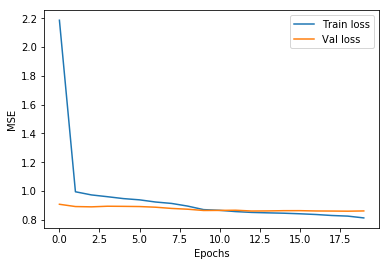

In [17]:
plot_loss(history)

In [18]:
mse_nn = eval_model(model_nn, "nn_weights.hdf5", test)

Mean Square Error for test data 0.93


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         2832        User[0][0]                       
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         5049        Movie[0][0]                      
__________________________________________________________________________________________________
FlattenUse

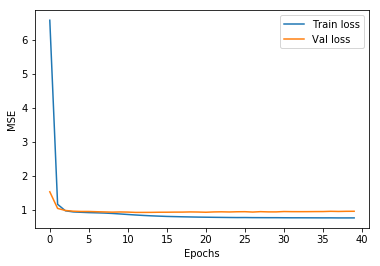

Mean Square Error for test data 0.98


In [19]:
# Build Factorization Model 
model_factor = recom.factorization_model()
model_factor.summary()

checkpointer = ModelCheckpoint(filepath="factor_weights.hdf5", verbose=0, save_best_only=True)

history = model_factor.fit([train.user_id, train.item_id], train.rating,
                    batch_size=64, epochs=40, validation_split=0.15,
                    shuffle=True, verbose=2, callbacks=[checkpointer])
plot_loss(history)
mse_factor = eval_model(model_factor, "factor_weights.hdf5", test)

## Plot the errors for different models

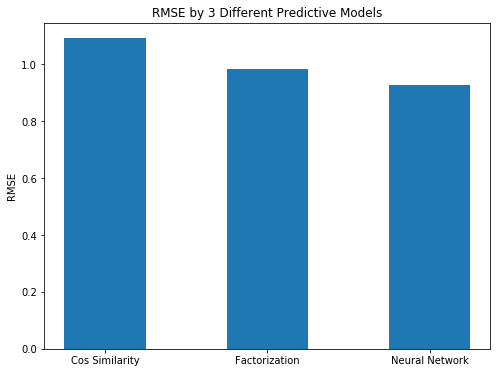

In [20]:
N = 3
errors = (mse_similarity, mse_factor, mse_nn)

ind = np.arange(N)  # the x locations for the groups
width = 0.5        # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches((8,6))
rects = ax.bar(ind, errors, width)

errors_rounded = (mse_similarity, mse_factor, mse_nn)


# add some text for labels, title and axes ticks
ax.set_ylabel('RMSE')
ax.set_title('RMSE by 3 Different Predictive Models')
ax.set_xticks(ind)
ax.set_xticklabels(('Cos Similarity', 'Factorization', 'Neural Network'))
plt.show()

## Evaluate the models based on precision and recall
## (updating..)

In [21]:
# trainBest = usersBestMovies(train, 1)
# testBest = usersBestMovies(test, 1)
# predBest_CosSim = recommendMovies(1, train, similarity=similarity, prediction_matrix=pred_Matrix)
# predBest_Factor = recommendMovies(1, train, model=model_Factorization)
# predBest_Factor_nonneg = recommendMovies(1, train, model=model_Factorization_nonneg)
# predBest_NN = recommendMovies(1, train, model=model_NN)

#### testBest

In [22]:
# def recall(test, pred):
#     pred = set(pred)
#     cnt = 0
#     for movie in test:
#         if movie in pred:
#             cnt += 1
#     return cnt / len(test)

# def precision(test, pred):
#     pred = set(pred)
#     cnt = 0
#     for movie in test:
#         if movie in pred:
#             cnt += 1
#     return cnt / len(pred)

# def precision_at_k(test, pred, k):
#     pred = set(pred[:k])
#     cnt = 0
#     for movie in test:
#         if movie in pred:
#             cnt += 1
#     return cnt / len(pred)

In [23]:
# print("Precision for Cosine Similarity Method: {0:.2f}"
#       .format(precision(testBest, predBest_CosSim)))
# print("Precision for Matrix Factorization: {0:.2f}"
#       .format(precision(testBest, predBest_Factor)))
# print("Precision for Non-negative Matrix Factorization: {0:.2f}"
#       .format(precision(testBest, predBest_Factor_nonneg)))
# print("Precision for FC Neural Network: {0:.2f}"
#       .format(precision(testBest, predBest_NN)))

In [24]:
# print("Recall for Cosine Similarity Method: {0:.2f}"
#       .format(recall(testBest, predBest_CosSim)))
# print("Recall for Matrix Factorization: {0:.2f}"
#       .format(recall(testBest, predBest_Factor)))
# print("Recall for Non-negative Matrix Factorization: {0:.2f}"
#       .format(recall(testBest, predBest_Factor_nonneg)))
# print("Recall for FC Neural Network: {0:.2f}"
#       .format(recall(testBest, predBest_NN)))